<a href="https://colab.research.google.com/github/bschelske/MMP9/blob/master/Ocky_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMP9 (Ocky) Paper figures.
**DONE** Need to create a MMP9 concentration calibration curve!

## Data that has been collected
https://docs.google.com/spreadsheets/d/18zbQfQOC_uKZ-fzjEftZiQgcsQlU6USrFntQx-sp59I/edit#gid=0

The notebook includes code for strip plots which compare the chamber intensities over time for varied cell types (A375, MDA MB 231, and MDA MB 231 with promotoer molecule (PMA))

To run code, mount drive. You may have to mount the ben drive such that paths match ben's drive paths or have the ben drive shared with you

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Figure 1: Strip Plot

Might have to install seaborn if `import seaborn as sns` isnt working

In [ ]:
# pip install seaborn

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import matplotlib.pyplot as plt

In [ ]:
def import_files():
  parent_dir = "/content/drive/My Drive/MMP9 Strip Plot/"
  files =[parent_dir+f for f in os.listdir(parent_dir) if os.path.isfile(parent_dir+f)]
  labels = [f[:-4] for f in os.listdir(parent_dir) if os.path.isfile(parent_dir+f)]
  # for f in labels: print(f)
  return files

def import_background_files():
  parent_dir = "/content/drive/My Drive/MMP9 Strip Plot/Background/"
  files =[parent_dir+f for f in os.listdir(parent_dir) if os.path.isfile(parent_dir+f)]
  labels = [f[:-4] for f in os.listdir(parent_dir) if os.path.isfile(parent_dir+f)]
  for f in labels: print(f)
  return files

def extract_sample_name(input_string):
    # Define the regular expression pattern to capture the desired substring
    pattern = r'/\d+_(.*?)_cells_only\.csv'

    # Use re.search to find the first match of the pattern in the input_string
    match = re.search(pattern, input_string)

    if match:
        # Extract the captured group (the substring within the parentheses) from the match
        return match.group(1)
    else:
        # Return None if no match is found
        return None


## 1) Create the big_df

Combines all of the processed intdencsvs into a usable dataframe

In [ ]:
files = import_files()

#Define headers for all dataframes going forward
strip_plot_df_headers = {'Time': [], 'Chamber':[], 'Intensity': [], 'Normal':[], 'Cell Type':[], 'Date':[], 'File':[], 'i':[]}

#Create dataframes using headers
strip_plot_df = pd.DataFrame(data=strip_plot_df_headers)
big_df = pd.DataFrame(data=strip_plot_df_headers)

#Used in the loop
i = 0

#Use regular expressions to extract chamber number from IntDenCSV
pattern = r'(\d+)'

#Loop that creates big_df from files within google drive
for file in files:
  temp_df = pd.DataFrame(data=strip_plot_df_headers)

  print('Importing '+file[40:-4])
  date = file[40:48]
  cell_type = extract_sample_name(file)

  df = pd.read_csv(file)
  df = df.rename(columns={ df.columns[0]: "Time" })

  cell_count = df.shape[1] - 1
  print(f'with {cell_count} chambers of {cell_type}')

  #Melt turns IntDenCSV files into nice format
  melt_df = pd.melt(df, id_vars=['Time'], var_name='Chamber', value_name='Intensity')
  melt_df['Chamber'] = melt_df['Chamber'].str.extract(pattern).astype(int)

  #Take good data from melt into correct format
  temp_df.loc[:,'Intensity'] = melt_df.loc[:,'Intensity']
  temp_df['Chamber'] = melt_df['Chamber']
  temp_df['Time'] = melt_df['Time']
  temp_df.loc[:,'Cell Type'] = cell_type
  temp_df.loc[:,'Date'] = date
  temp_df.loc[:,'File'] = file
  temp_df['i'] = i

  #Put the temp_df into a big_df
  big_df = pd.concat([big_df, temp_df])
  temp_df = temp_df.iloc[0:0] #delete the temp, if not then weird #$@! happens
  i = i+1

print('big_df created!')

Importing 20220527_A375_cells_only
with 37 chambers of A375
Importing 20220607_A375_cells_only
with 58 chambers of A375
Importing 20221012_MDA + PMA_cells_only
with 18 chambers of MDA + PMA
Importing 20220706_MDA MB 231_cells_only
with 39 chambers of MDA MB 231
Importing 20221116_MDA MB 231_cells_only
with 103 chambers of MDA MB 231
Importing 20221109_MDA + PMA_cells_only
with 75 chambers of MDA + PMA
Importing 20221102_MDA + PMA_cells_only
with 57 chambers of MDA + PMA
Importing 20220803_A375_cells_only
with 111 chambers of A375
Importing 20221121_MDA MB 231_cells_only
with 31 chambers of MDA MB 231
big_df created!


## 2) Introduce the_detective

from petdet notebook, the_detective is a list of which chambers contain cells.

In [ ]:
detective_save_path = '/content/drive/My Drive/the_detective.csv'
the_detective = pd.read_csv(detective_save_path)
the_detective = the_detective.iloc[:, 1:] #remove first unnamed column
the_detective.rename(columns={'Chamber #': 'Chamber'}, inplace=True)
the_detective.rename(columns={'Matching File': 'File'}, inplace=True)

# big_df['Date'] = big_df['Date'].astype(int)
big_df = big_df.merge(the_detective, on=['Chamber', 'File'], how='left')
big_df.rename(columns={'Cell Type_x': 'Cell Type'}, inplace=True)
big_df.rename(columns={'Date_x': 'Date'}, inplace=True)


In [ ]:
# Verify the merger made sense:
total_chambers = the_detective['Chamber'].count()
cell_sum = the_detective['Cell'].sum()

double_capture = the_detective[the_detective['Cell'] == 2].count()
multi_capture = the_detective[the_detective['Cell'] > 1].count()
total_capture = the_detective[the_detective['Cell'] > 0].count()
single_capture = the_detective[the_detective['Cell'] == 1].count()

big_df_A375 =big_df[(big_df['Cell Type']=='A375') & (big_df['Time']== 0)]
big_df_MDA = big_df[(big_df['Cell Type']=='MDA MB 231')  & (big_df['Time']== 0) ]
big_df_PMA = big_df[(big_df['Cell Type']=='MDA + PMA') & (big_df['Time']== 0)]

the_detective_A375 =the_detective[(the_detective['Cell Type']=='A375')]
the_detective_MDA = the_detective[(the_detective['Cell Type']=='MDA MB 231')]
the_detective_PMA = the_detective[(the_detective['Cell Type']=='MDA + PMA')]

count_the_detective_A375 = the_detective_A375['Cell'].sum()
count_the_detective_MDA  = the_detective_MDA['Cell'].sum()
count_the_detective_PMA  = the_detective_PMA['Cell'].sum()


count_A375 = big_df_A375['Cell'].sum()
count_MDA = big_df_MDA['Cell'].sum()
count_PMA = big_df_PMA['Cell'].sum()

if count_the_detective_A375 == count_A375: print('A375 pass')
else: print('A375 fail')

if count_the_detective_MDA == count_MDA: print('MDA pass')
else:  print('MDA fail')

if count_the_detective_PMA == count_PMA : print('PMA pass')
else:  print('PMA fail')

big_df_cell_sum = count_A375 + count_MDA + count_PMA


print(f'A375 Count: {count_A375}')
print(f'MDA Count: {count_MDA}')
print(f'PMA Count: {count_PMA}')
print(f'Total Count: {big_df_cell_sum}')


A375 pass
MDA pass
PMA pass
A375 Count: 212.0
MDA Count: 187.0
PMA Count: 169.0
Total Count: 568.0


In [ ]:
# Determine avg single cell capture from detective

the_detective
print(files)
average_results = []
for file in files:
  counting_df = the_detective.copy()
  counting_df = counting_df[(counting_df['File'] == file) & (counting_df['Cell']== 1)]
  sum = counting_df['Cell'].sum()
  average = sum / 160
  cell_type = counting_df['Cell Type'].iloc[0]
  result = {'Sum': sum,
            'Average': average,
            'Cell': cell_type
  }
  average_results.append(result)
  print(f'{cell_type}: (# of single cells / 160): {sum/160:.0%}')
the_detective_results = pd.DataFrame(average_results)
avg_avg = the_detective_results['Average'].mean()
print(f'avg_avg: {avg_avg:.0%}')

['/content/drive/My Drive/MMP9 Strip Plot/20220527_A375_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20220607_A375_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221012_MDA + PMA_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20220706_MDA MB 231_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221116_MDA MB 231_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221109_MDA + PMA_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221102_MDA + PMA_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20220803_A375_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221121_MDA MB 231_cells_only.csv']
A375: (# of single cells / 160): 23%
A375: (# of single cells / 160): 36%
MDA + PMA: (# of single cells / 160): 11%
MDA MB 231: (# of single cells / 160): 23%
MDA MB 231: (# of single cells / 160): 63%
MDA + PMA: (# of single cells / 160): 45%
MDA + PMA: (# of single cells / 160): 26%
A375: (# of single cells / 160):

## 3) Strip plot

This block of code creates the strip plot for intensities vs time for varied cell types. It also calculates the avg and max fold at t 120 for each cell type and prints the result.

Single Cell Capture:

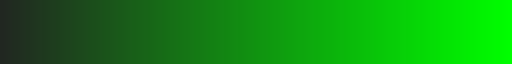

In [ ]:
sns.color_palette("dark:lime", as_cmap=True)

A375 Average: 2.27 std: 1.29 Max: 6.89
MDA Average: 1.25 std: 0.38 Max: 2.63
PMA Average: 1.32 std: 0.84 Max: 4.35


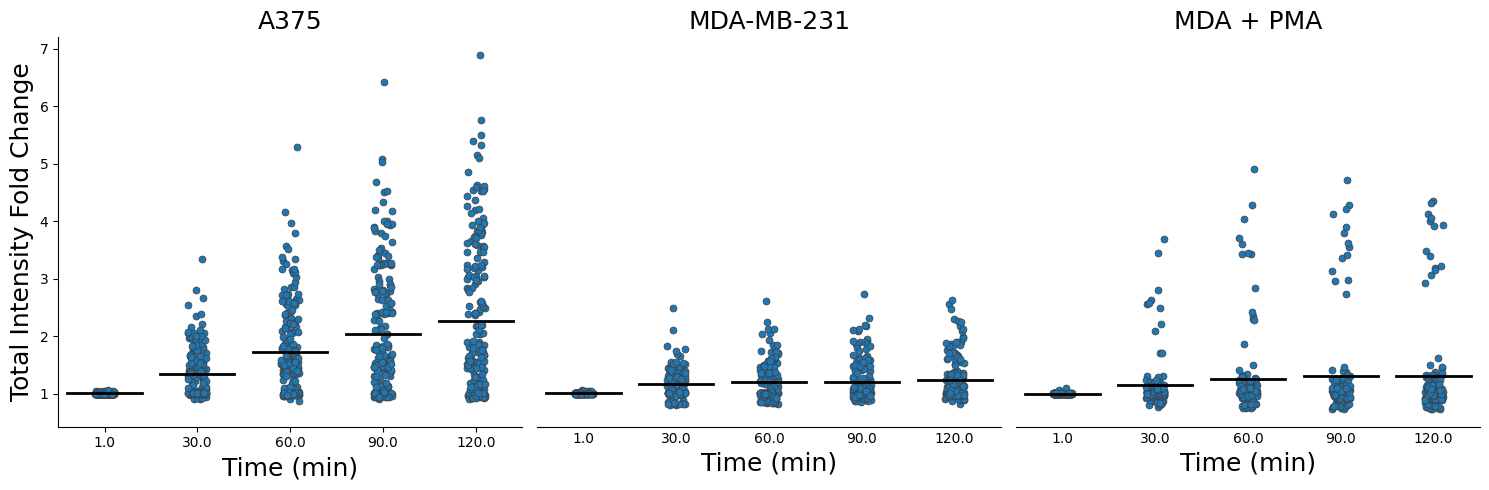

In [ ]:
#Create a copy of the big_df to make a plot out of
plot_times = [1, 30, 60, 90, 120]
strip_plot_df = big_df[big_df["Time"].isin(plot_times)].copy()
strip_plot_df = strip_plot_df[strip_plot_df["Cell"]==1]


# Define the order of categories for the 'Cell Type' column and y axis
cell_type_order = ['A375', 'MDA MB 231', 'MDA + PMA']
y = 'Intensity'

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, len(cell_type_order), figsize=(15, 5), sharey=True)

# Loop through each 'Cell Type' and plot it in the corresponding subplot
for i, cell_type in enumerate(cell_type_order):
    cell_strip_df = strip_plot_df[strip_plot_df['Cell Type'] == cell_type]
    # cell_strip_df = cell_strip_df[cell_strip_df['Cell'] == cell_type]


    # strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, legend=False, ax=axes[i], color = 'k' ,hue = y, palette = sns.color_palette("dark:lime", as_cmap=True), linewidth = .5)
    strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, legend=False, ax=axes[i], linewidth = .5)

    # Plot the average only when the fold change is positive
    sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False}, whiskerprops={'visible': False},
                zorder=10, x='Time', y=y, data=cell_strip_df[cell_strip_df['Intensity']>0],
                showfliers=False, showbox=False, showcaps=False, ax=axes[i])

    #Plot the average of the entire data range
    # # sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'r', 'ls': '-', 'lw': 2},
    #             medianprops={'visible': False}, whiskerprops={'visible': False},
    #             zorder=10, x='Time', y=y, data=cell_strip_df,
    #             showfliers=False, showbox=False, showcaps=False, ax=axes[i])


    # Set the title for each subplot
    if cell_type == 'MDA MB 231':
      axes[i].set_title('MDA-MB-231', font = {'size':18})
    else:
      axes[i].set_title(cell_type, font = {'size':18})

    # Set the spines (axes lines) to be invisible
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(True)
    axes[i].spines['left'].set_visible(True)

    #Set axis labels
    axes[i].set_ylabel('Total Intensity Fold Change', font = {'size':18})
    axes[i].set_xlabel('Time (min)', font = {'size':18})

    # Remove ticks from the x and y axes
    # axes[i].tick_params(axis='both', which='both', length=0)

    # Remove axis label and spines for all subplots except the first one
    if i > 0:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='both', which='both', length=0)

        pass


find_avg_df = strip_plot_df[strip_plot_df['Intensity']>0]

filtered_df_A = find_avg_df[(find_avg_df['Cell Type'] == 'A375') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_A['Intensity'].mean()
a_max = filtered_df_A['Intensity'].max()
a_std = filtered_df_A['Intensity'].std()
stat_string = f"A375 Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)

filtered_df_M = find_avg_df[(find_avg_df['Cell Type'] == 'MDA MB 231') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_M['Intensity'].mean()
a_max = filtered_df_M['Intensity'].max()
a_std = filtered_df_M['Intensity'].std()
stat_string = f"MDA Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)

filtered_df_P = find_avg_df[(find_avg_df['Cell Type'] == 'MDA + PMA') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_P['Intensity'].mean()
a_max = filtered_df_P['Intensity'].max()
a_std = filtered_df_P['Intensity'].std()
stat_string = f"PMA Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)


# Adjust the space between subplots
plt.tight_layout()

# Show the combined plot

#Font
font = {'size':20, 'fontweight':'bold'} #BOLD Version
# font = {'size':18}

#Change title
# plt.title(title, fontdict = font)

#Change axis labels
# plt.xlabel(xaxis, fontdict = font)
# plt.ylabel(yaxis, fontdict = font)

plt.show()


In [ ]:
import numpy as np
from scipy import stats
stats.ttest_ind(filtered_df_M['Intensity'], filtered_df_P['Intensity'])


TtestResult(statistic=-0.9068654386153582, pvalue=0.3652334638693596, df=289.0)

A375 Average: 2.28 std: 1.28 Max: 6.89
MDA Average: 1.36 std: 0.73 Max: 5.37
PMA Average: 1.40 std: 0.92 Max: 4.59


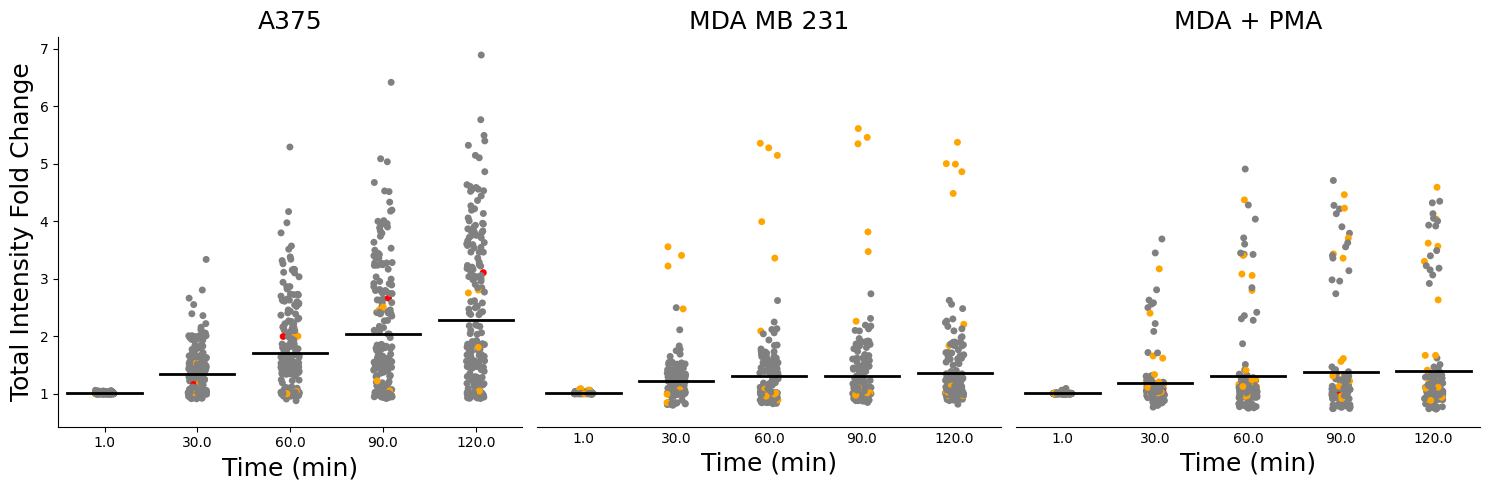

In [ ]:
#Create a copy of the big_df to make a plot out of
plot_times = [1, 30, 60, 90, 120]
strip_plot_df = big_df[big_df["Time"].isin(plot_times)].copy()

value_to_color = {1: 'blue', 2: 'orange', 3: 'red'}
custom_palette = {'blue':'grey', 'orange':'orange', 'red':'red'}

# Add a 'Color' column based on the mapping
strip_plot_df['Color'] = strip_plot_df['Cell'].map(value_to_color)

# Define the order of categories for the 'Cell Type' column and y axis
cell_type_order = ['A375', 'MDA MB 231', 'MDA + PMA']
y = 'Intensity'

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, len(cell_type_order), figsize=(15, 5), sharey=True)

# Loop through each 'Cell Type' and plot it in the corresponding subplot
for i, cell_type in enumerate(cell_type_order):
    cell_strip_df = strip_plot_df[strip_plot_df['Cell Type'] == cell_type]
    # cell_strip_df = cell_strip_df[cell_strip_df['Cell'] == cell_type]


    strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, legend=False, ax=axes[i], hue = strip_plot_df['Color'], dodge= False, palette =custom_palette)

    # Plot the average only when the fold change is positive
    sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False}, whiskerprops={'visible': False},
                zorder=10, x='Time', y=y, data=cell_strip_df[cell_strip_df['Intensity']>0],
                showfliers=False, showbox=False, showcaps=False, ax=axes[i])

    #Plot the average of the entire data range
    # # sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'r', 'ls': '-', 'lw': 2},
    #             medianprops={'visible': False}, whiskerprops={'visible': False},
    #             zorder=10, x='Time', y=y, data=cell_strip_df,
    #             showfliers=False, showbox=False, showcaps=False, ax=axes[i])


    # Set the title for each subplot
    axes[i].set_title(cell_type, font = {'size':18})

    # Set the spines (axes lines) to be invisible
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(True)
    axes[i].spines['left'].set_visible(True)

    #Set axis labels
    axes[i].set_ylabel('Total Intensity Fold Change', font = {'size':18})
    axes[i].set_xlabel('Time (min)', font = {'size':18})

    # Remove ticks from the x and y axes
    # axes[i].tick_params(axis='both', which='both', length=0)

    # Remove axis label and spines for all subplots except the first one
    if i > 0:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='both', which='both', length=0)

        pass


find_avg_df = strip_plot_df[strip_plot_df['Intensity']>0]

filtered_df_A = find_avg_df[(find_avg_df['Cell Type'] == 'A375') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_A['Intensity'].mean()
a_max = filtered_df_A['Intensity'].max()
a_std = filtered_df_A['Intensity'].std()
stat_string = f"A375 Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)

filtered_df_M = find_avg_df[(find_avg_df['Cell Type'] == 'MDA MB 231') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_M['Intensity'].mean()
a_max = filtered_df_M['Intensity'].max()
a_std = filtered_df_M['Intensity'].std()
stat_string = f"MDA Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)

filtered_df_P = find_avg_df[(find_avg_df['Cell Type'] == 'MDA + PMA') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_P['Intensity'].mean()
a_max = filtered_df_P['Intensity'].max()
a_std = filtered_df_P['Intensity'].std()
stat_string = f"PMA Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)


# Adjust the space between subplots
plt.tight_layout()

# Show the combined plot

#Font
font = {'size':20, 'fontweight':'bold'} #BOLD Version
# font = {'size':18}

#Change title
# plt.title(title, fontdict = font)

#Change axis labels
# plt.xlabel(xaxis, fontdict = font)
# plt.ylabel(yaxis, fontdict = font)

plt.show()


## Troubleshooting

looking closer at 2x2 binning, as well as MDA + PMA distribution

Gives count of total amount of cells of each type

In [ ]:
#Returns the number of cells for each type. may need to make plot first

# strip_plot_df = strip_plot_df[~strip_plot_df['File'].str.contains('/content/drive/My Drive/MMP9 Strip Plot/20221116_MDA MB 231_cells_only.csv')]

count_df = strip_plot_df.copy()
count_df = count_df[count_df['Time']==(plot_times[0])]

A375_df = count_df[count_df['Cell Type']==('A375')]
MDA_df = count_df[count_df['Cell Type']==('MDA MB 231')]
PMA_df = count_df[count_df['Cell Type']==('MDA + PMA')]

A375_count = count_df['Cell Type'].value_counts()['A375']
MDA_PMA_count = count_df['Cell Type'].value_counts()['MDA + PMA']
MDA_count = count_df['Cell Type'].value_counts()['MDA MB 231']

print(f"A375 Count: {A375_count}")
print(f"MDA + PMA Count: {MDA_PMA_count}")
print(f"MDA MB 231 Count: {MDA_count}")

A375 Count: 206
MDA + PMA Count: 150
MDA MB 231 Count: 173


Files that are binned:

20221116_MDA MB 231_raw_cells_only.csv

20221102_MDA +PMA_raw_cells_only.csv

20221012_MDA +PMA_raw_cells_only.csv (lloks messed up )

20220706_MDA MB 231_raw_cells_only.csv


Following block is a strip plot of just MDA/MDA+PMA. Colors according to file can be added


['/content/drive/My Drive/MMP9 Strip Plot/20221116_MDA MB 231_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221102_MDA + PMA_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20221012_MDA + PMA_cells_only.csv', '/content/drive/My Drive/MMP9 Strip Plot/20220706_MDA MB 231_cells_only.csv']
A375 2.275569401551191
MDA 1.3561688943378176
PMA 1.3986028371623342


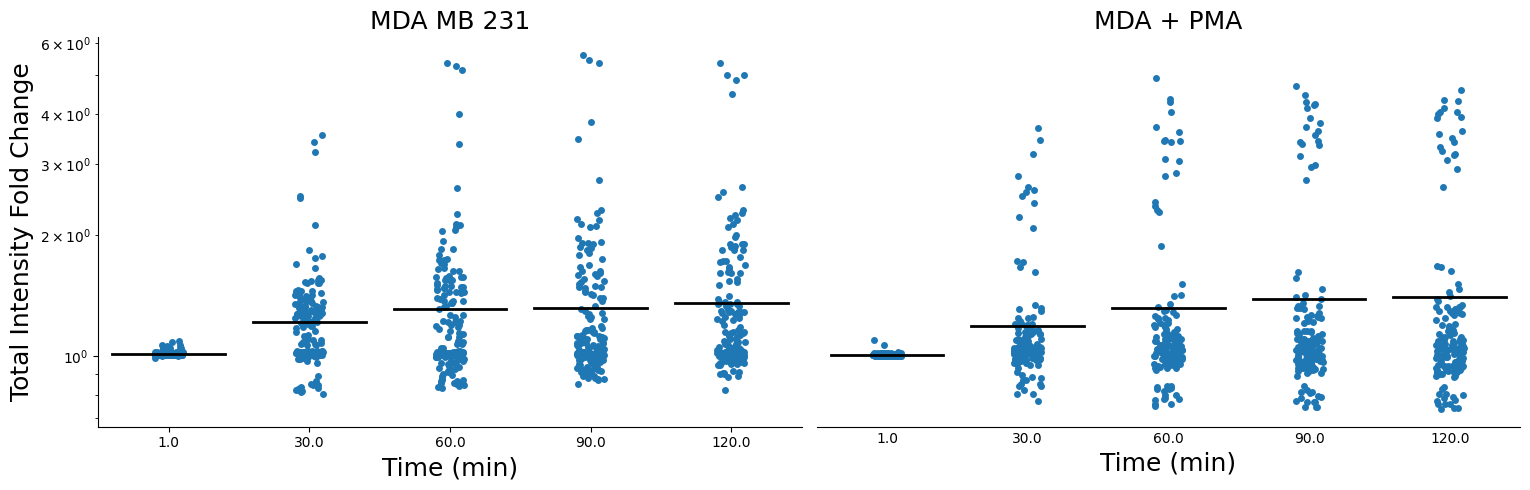

In [ ]:
#Get list of binned files:
updated_path ='/content/drive/My Drive/MMP9 Strip Plot/'

files_before_name = ['20221116_MDA MB 231_cells_only.csv', '20221102_MDA + PMA_cells_only.csv', '20221012_MDA + PMA_cells_only.csv', '20220706_MDA MB 231_cells_only.csv']
binned_files = []
binned_colors = ['r', 'b', 'g', 'm']
for item in files_before_name:
  new_name = updated_path+item
  binned_files.append(new_name)

print(binned_files)
file_to_color_map = dict(zip(binned_files, binned_colors))
custom_palette = {'r': 'red', 'b': 'blue', 'g': 'green', 'm': 'magenta', 'k':'gray'}

strip_plot_df['Color'] = strip_plot_df['File'].map(file_to_color_map).fillna('k')


# Define the order of categories for the 'Cell Type' column and y axis
cell_type_order = ['MDA MB 231', 'MDA + PMA']
y = 'Intensity'

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, len(cell_type_order), figsize=(15, 5), sharey=True)

# Loop through each 'Cell Type' and plot it in the corresponding subplot
for i, cell_type in enumerate(cell_type_order):
    cell_strip_df = strip_plot_df[strip_plot_df['Cell Type'] == cell_type]

    # Plot the stripplot
    # strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, hue='Normal',
    #                           palette='coolwarm', legend=False, ax=axes[i])

    strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, legend=False, ax=axes[i])
    # strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, legend=False, ax=axes[i], hue='Color', palette=custom_palette )

    # Plot the average only when the fold change is positive
    sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False}, whiskerprops={'visible': False},
                zorder=10, x='Time', y=y, data=cell_strip_df[cell_strip_df['Intensity']>0],
                showfliers=False, showbox=False, showcaps=False, ax=axes[i])

    #Plot the average of the entire data range
    # # sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'r', 'ls': '-', 'lw': 2},
    #             medianprops={'visible': False}, whiskerprops={'visible': False},
    #             zorder=10, x='Time', y=y, data=cell_strip_df,
    #             showfliers=False, showbox=False, showcaps=False, ax=axes[i])


    # Set the title for each subplot
    axes[i].set_title(cell_type, font = {'size':18})

    # Set the spines (axes lines) to be invisible
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(True)
    axes[i].spines['left'].set_visible(True)

    #Set axis labels
    axes[i].set_ylabel('Total Intensity Fold Change', font = {'size':18})
    axes[i].set_xlabel('Time (min)', font = {'size':18})

    # Remove ticks from the x and y axes
    # axes[i].tick_params(axis='both', which='both', length=0)

    # Remove axis label and spines for all subplots except the first one
    if i > 0:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='both', which='both', length=0)

        pass


find_avg_df = strip_plot_df[strip_plot_df['Intensity']>0]

filtered_df_A = find_avg_df[(find_avg_df['Cell Type'] == 'A375') & (find_avg_df['Time'] == 120)]
print('A375 ' + str(filtered_df_A['Intensity'].mean()))

filtered_df_M = find_avg_df[(find_avg_df['Cell Type'] == 'MDA MB 231') & (find_avg_df['Time'] == 120)]
print('MDA ' + str(filtered_df_M['Intensity'].mean()))

filtered_df_P = find_avg_df[(find_avg_df['Cell Type'] == 'MDA + PMA') & (find_avg_df['Time'] == 120)]
print('PMA ' + str(filtered_df_P['Intensity'].mean()))

# Show the legend outside the subplots
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the space between subplots
plt.tight_layout()
plt.yscale('log')
# plt.ylim(bottom=0.00000000000001)
# Show the combined plot

# title = 'A375 MMP9 Secretion'
# xaxis = 'Time (min)'
# yaxis = 'Norm. Total Intensity per\ncell containing chamber (a.u.)'

#Font
# font = {'size':20, 'fontweight':'bold'} #BOLD Version
font = {'size':18}

#Change title
# plt.title(title, fontdict = font)

#Change axis labels
# plt.xlabel(xaxis, fontdict = font)
# plt.ylabel(yaxis, fontdict = font)

plt.show()


In [ ]:
#Determine mean values for each time for each cell type

#Define headers for all dataframes going forward
strip_plot_df_headers = {'Time': [], 'Chamber':[], 'Intensity': [], 'Normal':[], 'Cell Type':[], 'Date':[], 'File':[], 'i':[]}

#Create dataframes using headers
avg_plot_df = pd.DataFrame(data=strip_plot_df_headers)
averages=[]
#Define cell types
cell_type_order = ['A375', 'MDA MB 231', 'MDA + PMA']

#Loop through each cell type
for cell_type in cell_type_order:
  cell_strip_df = strip_plot_df[strip_plot_df['Cell Type'] == cell_type]
  for time in plot_times:
    average = cell_strip_df[cell_strip_df['Time'] == time]['Normal'].mean()
    averages.append(average)
print(averages)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


# ???

All ??? is probably uninteresting

multiple strip plots showing averages:

8


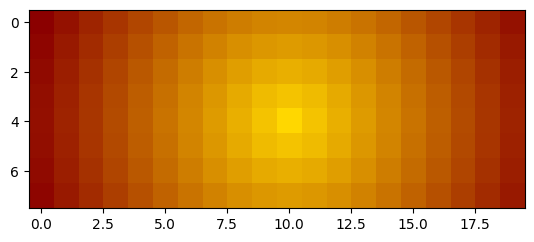

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
del df

values = np.arange(1, 161)  # Starts at 1, ends at 160 (20x8 = 160)

# Reshape the 1D array into a 20x8 array
matrix = values.reshape(8, 20)


# Calculate the distance of each cell from the center
n, m = matrix.shape
y, x = np.ogrid[:n, :m]
y_center, x_center = n // 2, m // 2
distances = np.sqrt((x - x_center) ** 2 + (y - y_center) ** 2)

# Define your colormap with colors for "close" and "far" values
colors = ["gold", "darkred"]  # You can adjust these colors as needed
colormap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

# Normalize the distances to the range [0, 1]
normalized_distances = distances / distances.max()
flat_distance = normalized_distances.flatten()
df = pd.DataFrame(flat_distance)
df = df.rename(columns={ df.columns[0]: "To Edge Color" })
df['Chamber'] = range(1, len(df) + 1)

# Create an array of colors based on the normalized distances
color_array = colormap(normalized_distances)

# Create a figure
fig, ax = plt.subplots()

# Display the colored matrix as an image
ax.imshow(color_array)

print(len(color_array))

# Show the plot
plt.show()


A375 Average: 2.28 std: 1.28 Max: 6.89
MDA Average: 1.36 std: 0.73 Max: 5.37
PMA Average: 1.40 std: 0.92 Max: 4.59


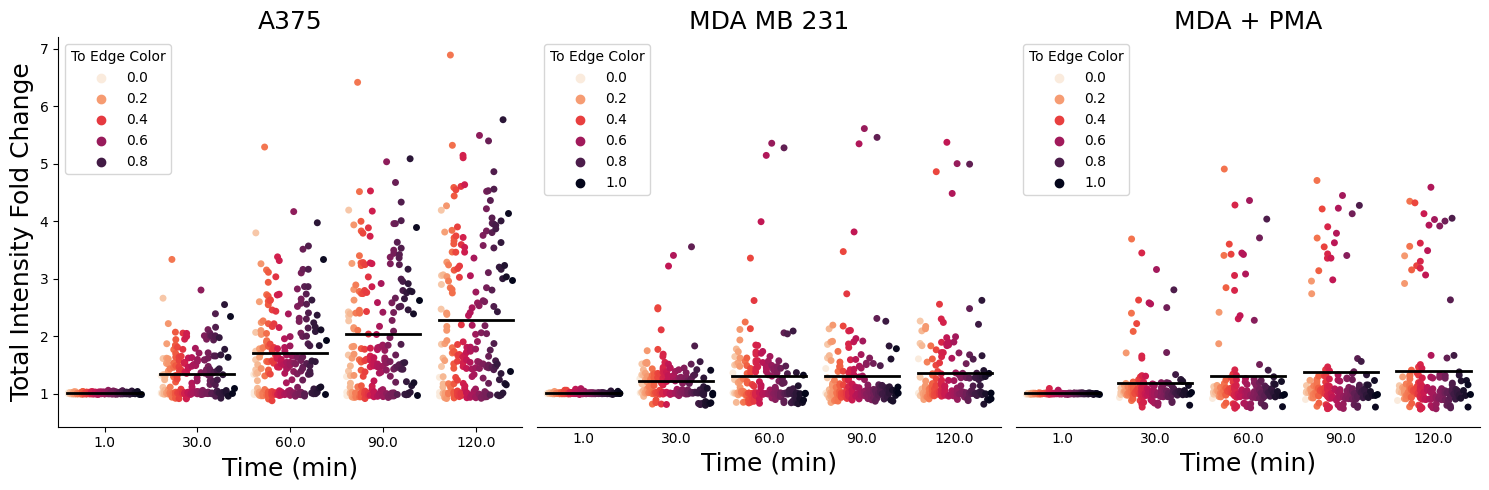

In [ ]:
#Create a copy of the big_df to make a plot out of
plot_times = [1, 30, 60, 90, 120]
strip_plot_df = big_df[big_df["Time"].isin(plot_times)].copy()

# Proximity Color Merge
strip_plot_df = strip_plot_df.merge(df, on=['Chamber'], how='left')

# Define the order of categories for the 'Cell Type' column and y axis
cell_type_order = ['A375', 'MDA MB 231', 'MDA + PMA']
y = 'Intensity'

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, len(cell_type_order), figsize=(15, 5), sharey=True)

# Loop through each 'Cell Type' and plot it in the corresponding subplot
for i, cell_type in enumerate(cell_type_order):
    cell_strip_df = strip_plot_df[strip_plot_df['Cell Type'] == cell_type]
    # cell_strip_df = cell_strip_df[cell_strip_df['Cell'] == cell_type]


    strip_plot = sns.stripplot(data=cell_strip_df, x='Time', y=y, legend=True, ax=axes[i], hue ='To Edge Color', palette= 'rocket_r', dodge=True)

    # Plot the average only when the fold change is positive
    sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False}, whiskerprops={'visible': False},
                zorder=10, x='Time', y=y, data=cell_strip_df[cell_strip_df['Intensity']>0],
                showfliers=False, showbox=False, showcaps=False, ax=axes[i])

    #Plot the average of the entire data range
    # # sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'r', 'ls': '-', 'lw': 2},
    #             medianprops={'visible': False}, whiskerprops={'visible': False},
    #             zorder=10, x='Time', y=y, data=cell_strip_df,
    #             showfliers=False, showbox=False, showcaps=False, ax=axes[i])


    # Set the title for each subplot
    axes[i].set_title(cell_type, font = {'size':18})

    # Set the spines (axes lines) to be invisible
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(True)
    axes[i].spines['left'].set_visible(True)

    #Set axis labels
    axes[i].set_ylabel('Total Intensity Fold Change', font = {'size':18})
    axes[i].set_xlabel('Time (min)', font = {'size':18})

    # Remove ticks from the x and y axes
    # axes[i].tick_params(axis='both', which='both', length=0)

    # Remove axis label and spines for all subplots except the first one
    if i > 0:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='both', which='both', length=0)

        pass


find_avg_df = strip_plot_df[strip_plot_df['Intensity']>0]

filtered_df_A = find_avg_df[(find_avg_df['Cell Type'] == 'A375') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_A['Intensity'].mean()
a_max = filtered_df_A['Intensity'].max()
a_std = filtered_df_A['Intensity'].std()
stat_string = f"A375 Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)

filtered_df_M = find_avg_df[(find_avg_df['Cell Type'] == 'MDA MB 231') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_M['Intensity'].mean()
a_max = filtered_df_M['Intensity'].max()
a_std = filtered_df_M['Intensity'].std()
stat_string = f"MDA Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)

filtered_df_P = find_avg_df[(find_avg_df['Cell Type'] == 'MDA + PMA') & (find_avg_df['Time'] == 120)]
a_avg = filtered_df_P['Intensity'].mean()
a_max = filtered_df_P['Intensity'].max()
a_std = filtered_df_P['Intensity'].std()
stat_string = f"PMA Average: {a_avg:.2f} std: {a_std:.2f} Max: {a_max:.2f}"
print(stat_string)


# Adjust the space between subplots
plt.tight_layout()

# Show the combined plot

#Font
font = {'size':20, 'fontweight':'bold'} #BOLD Version
# font = {'size':18}

#Change title
# plt.title(title, fontdict = font)

#Change axis labels
# plt.xlabel(xaxis, fontdict = font)
# plt.ylabel(yaxis, fontdict = font)

plt.show()


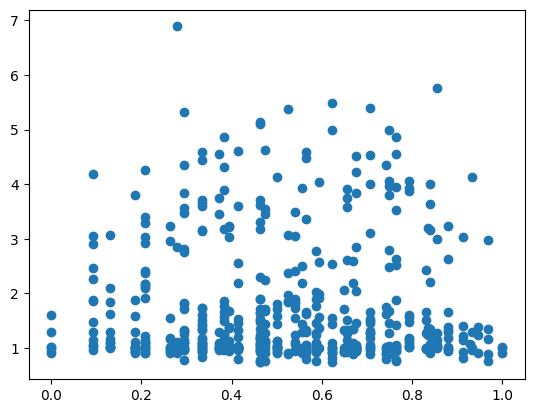

In [ ]:
strip_plot_df = big_df[big_df["Time"].isin(plot_times)].copy()
strip_plot_df = strip_plot_df.merge(df, on=['Chamber'], how='left')
strip_plot_df = strip_plot_df[strip_plot_df['Time'] == 120]

plt.scatter(data=strip_plot_df, x='To Edge Color', y='Intensity')


<ipython-input-19-9d6a28b8f119>:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  A375_strip_plot = sns.stripplot(data=A375_strip_df, x ='Time', y=y, hue='Normal', palette='coolwarm', legend =False)


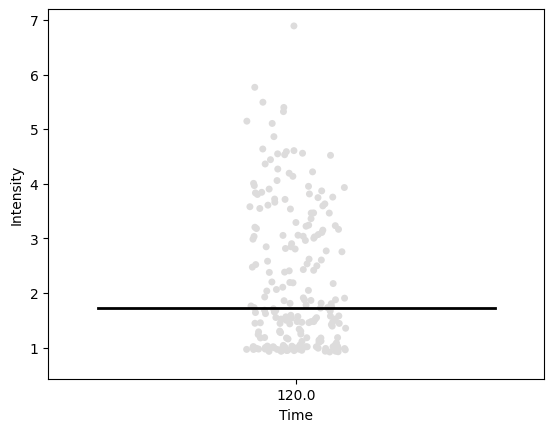

In [ ]:
#A375 Plot with averages
A375_strip_df = strip_plot_df[strip_plot_df['Cell Type']==('A375')]
A375_strip_plot = sns.stripplot(data=A375_strip_df, x ='Time', y=y, hue='Normal', palette='coolwarm', legend =False)
A375_strip_plot = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="Time",
            y="Intensity",
            data=strip_plot_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=A375_strip_plot)

<ipython-input-20-d9686ca5f9df>:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  MDA_strip_plot = sns.stripplot(data=MDA_strip_df, x ='Time', y=y, hue='Normal', palette='coolwarm', legend =False)


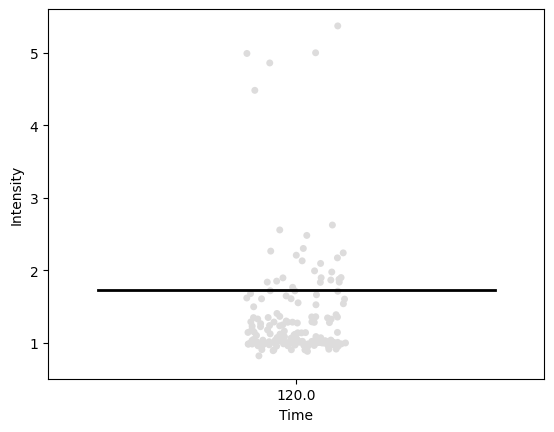

In [ ]:
#MDA plot with averages
MDA_strip_df = strip_plot_df[strip_plot_df['Cell Type']==('MDA MB 231')]
MDA_strip_plot = sns.stripplot(data=MDA_strip_df, x ='Time', y=y, hue='Normal', palette='coolwarm', legend =False)
MDA_strip_plot = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="Time",
            y="Intensity",
            data=strip_plot_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=MDA_strip_plot)

<ipython-input-21-12280eb3d0d1>:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  PMA_strip_plot = sns.stripplot(data=PMA_strip_df, x ='Time', y='Intensity', hue='Normal', palette='coolwarm', legend =False)


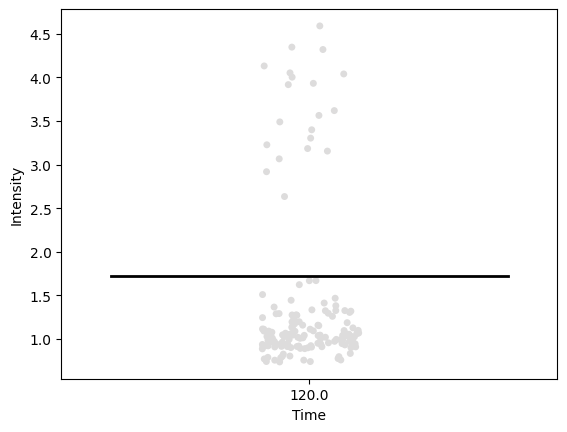

In [ ]:
PMA_strip_df = strip_plot_df[strip_plot_df['Cell Type']==('MDA + PMA')]
PMA_strip_plot = sns.stripplot(data=PMA_strip_df, x ='Time', y='Intensity', hue='Normal', palette='coolwarm', legend =False)
PMA_strip_plot = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="Time",
            y="Intensity",
            data=strip_plot_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=PMA_strip_plot)


<ipython-input-22-6a829fcd13c9>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  catplot = sns.catplot(data=strip_plot_df, x="Time", y="Intensity", col_order = ['A375' , 'MDA MB 231', 'MDA + PMA'],


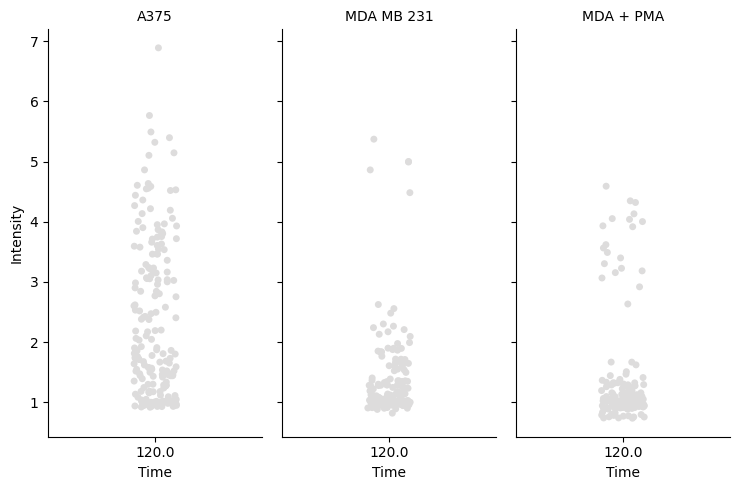

In [ ]:
catplot = sns.catplot(data=strip_plot_df, x="Time", y="Intensity", col_order = ['A375' , 'MDA MB 231', 'MDA + PMA'],
            hue="Normal", palette='coolwarm', col="Cell Type", aspect=.5, legend =False
            )
catplot.set_titles("{col_name}")
# catplot.despine(left=True, bottom=False)

## Create a category plot
Creates a category plot catplot comparing A375, MDA MB 231, and MDA + PMA. The catplot is slightly difficult to work with... future code is going to create separate strip plots onto the same figure. Strip plots are nice because you can also plot the average on them.

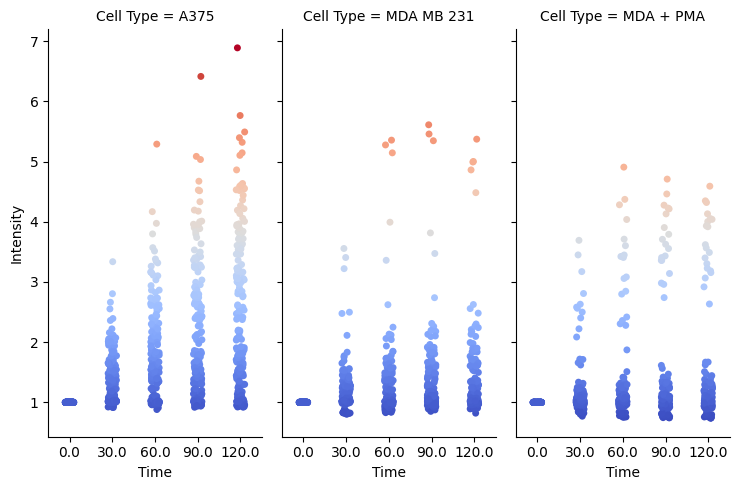

In [ ]:
# Category plot is an early attempt at stip plot.

#Define times to plot and y axis
plot_times = [0, 30, 60, 90, 120]
y = 'Intensity'  #'Intensity' or normalized intensity 'Normal'

#Create a copy of the big_df to make a plot out of
strip_plot_df = big_df[big_df["Time"].isin(plot_times)].copy()


# Normalization Paramaters
maximum = strip_plot_df['Intensity'].max()
minimum = strip_plot_df['Intensity'].min()
upper_limit = 1000
lower_limit = 0.001

# Modify the 'Normal' column directly on the original DataFrame
strip_plot_df.loc[:,'Normal'] = (((upper_limit - lower_limit)*(strip_plot_df['Intensity'] - minimum) / (maximum - minimum)) + lower_limit)

#Dicarlo Normalization (ratio to empty chamber)
# strip_plot_df.loc[:,'Normal'] = ((strip_plot_df['Intensity'] - minimum) / (maximum - minimum)) + lower_limit)

#stipplot of all intensities over time, no cell differentiation
# strip_plot = sns.stripplot(data=strip_plot_df, x ='Time', y='Intensity', hue='Normal', palette='coolwarm', legend =False)
# MDA_plot = sns.stripplot(data=MDA_df, x ='Time', y='Intensity', hue='Normal', palette='coolwarm', legend =False)

#striplot divided by cell type
cell_type_order = ['A375', 'MDA MB 231', 'MDA + PMA']

catplot = sns.catplot(data=strip_plot_df, x="Time", y=y,
                      col_order = cell_type_order, hue="Normal", palette='coolwarm', col="Cell Type", aspect=.5, legend =False
            )


title = 'A375 MMP9 Secretion'
xaxis = 'Time (min)'
yaxis = 'Norm. Total Intensity per\ncell containing chamber (a.u.)'

#Font
# font = {'size':20, 'fontweight':'bold'} #BOLD Version
font = {'size':18}

#Change title
# plt.title(title, fontdict = font)

#Change axis labels
# plt.xlabel(xaxis, fontdict = font)
# plt.ylabel(yaxis, fontdict = font)
